Shor Code ESM

In [19]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import random_statevector, Statevector
from numpy import pi

In [13]:

q_input = QuantumRegister(1, 'variable')
q = QuantumRegister(8, "q_")
a = QuantumRegister(8, "a")
c = ClassicalRegister(8, 'c')

Shor Code ESM implementation

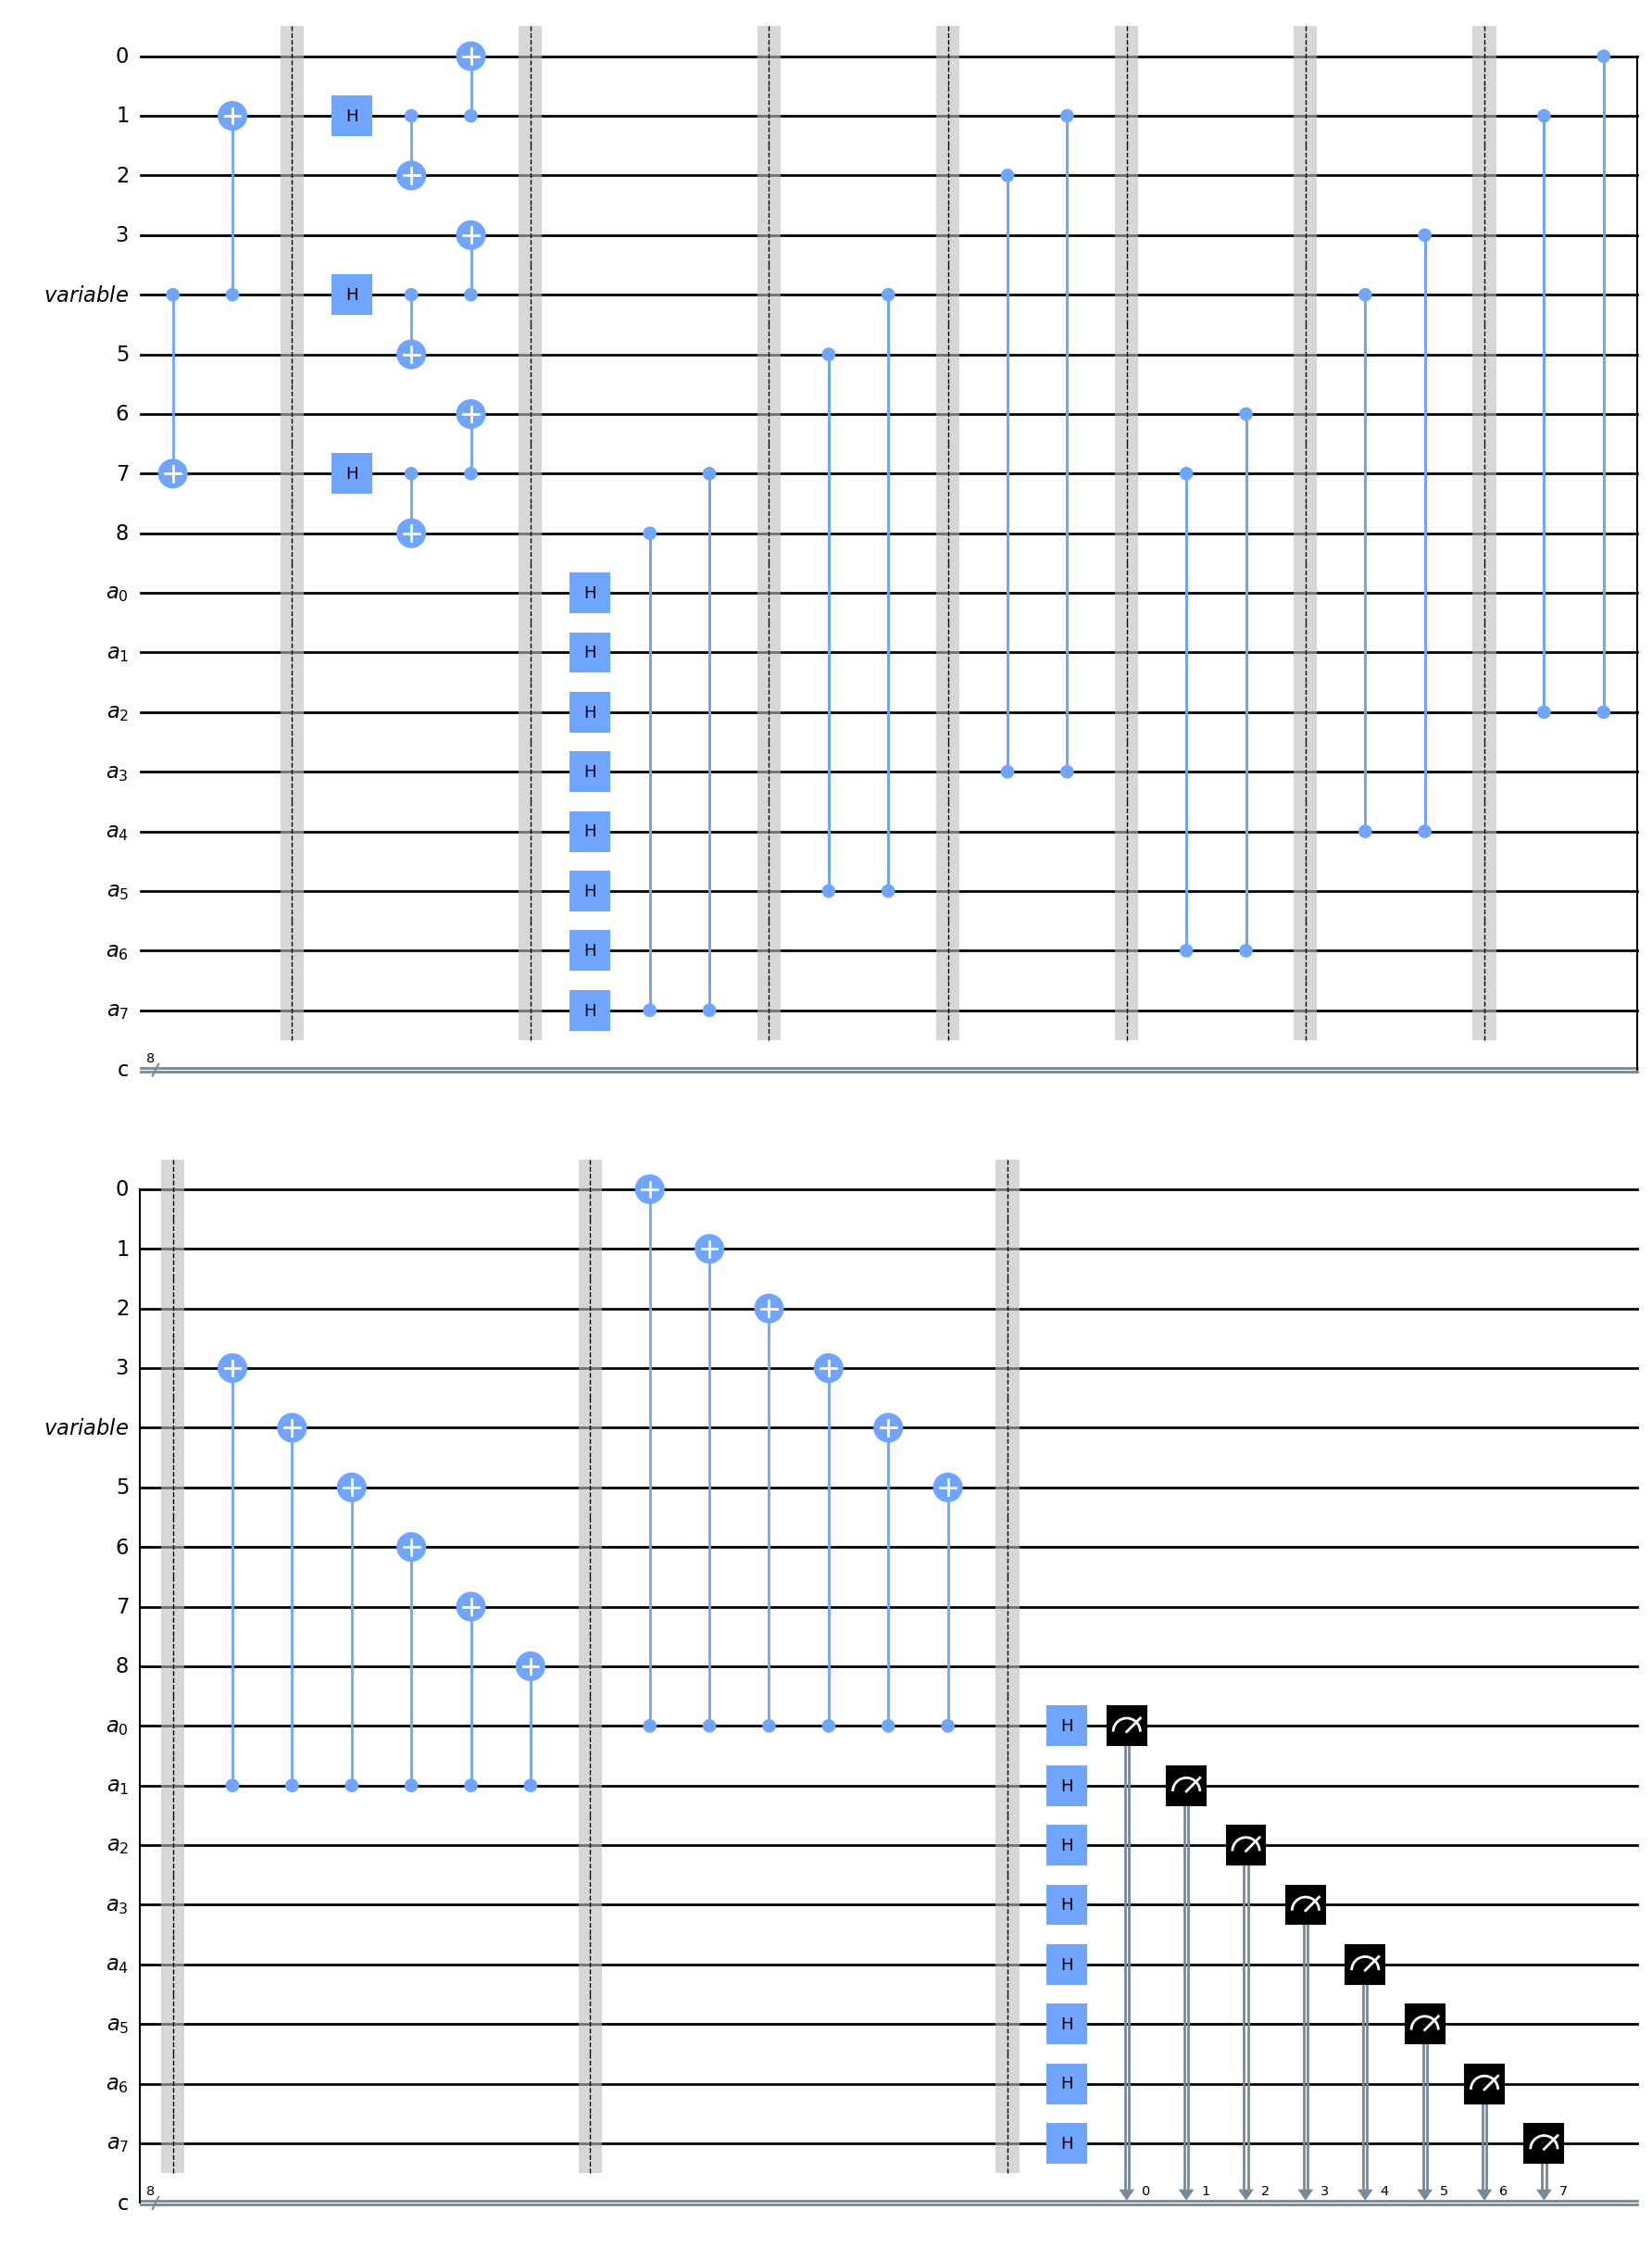

In [14]:
circ = QuantumCircuit(q[:4], q_input, q[4:], a, c)

def barrier():
    circ.barrier(q[:4],q_input,q[4:],a)

circ.cx(q_input[0], q[6])
circ.cx(q_input[0], q[1])
barrier()
circ.h(q[1])
circ.h(q_input[0])
circ.h(q[6])
circ.cx(q[1], q[2])
circ.cx(q_input[0], q[4])
circ.cx(q[6], q[7])
circ.cx(q[1], q[0])
circ.cx(q_input[0], q[3])
circ.cx(q[6], q[5])
barrier()
for x in a:
    circ.h(x)
circ.cz(q[7],a[7])
circ.cz(q[6],a[7])
barrier()
circ.cz(q[4],a[5])
circ.cz(q_input[0],a[5])
barrier()
circ.cz(q[2],a[3])
circ.cz(q[1],a[3])
barrier()
circ.cz(q[6],a[6])
circ.cz(q[5],a[6])
barrier()
circ.cz(q_input[0],a[4])
circ.cz(q[3],a[4])
barrier()
circ.cz(q[1],a[2])
circ.cz(q[0],a[2])
barrier()
for i in range(3,9):
    circ.cx(a[1], i)
barrier()
for i in range(0,6):
    circ.cx(a[0], i)
barrier()
for i in range(8) :
    circ.h(a[i])
    circ.measure(a[i],c[i])
circ.draw('mpl')

In [21]:
#state = Statevector.from_int(0, 2**9)
#state.draw('latex')
vec = random_statevector(9)
# vec = Statevector([1, 0])
print('before circuit: {}'.format(vec)) 

before circuit: Statevector([0.79445334-0.32846457j, 0.02411927+0.51026775j],
            dims=(2,))


In [20]:
state = state.evolve(circ)
state.draw('latex')

ValueError: axes don't match array